<a href="https://colab.research.google.com/github/limalkasadith/DSA-Bootcamp-Java/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import datetime
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
# if torch.cuda.is_available():
#     device = torch.device("cuda")
#     print("GPU is available!!!!")
# else:
#     device = torch.device("cpu")
#     print("GPU is not available, using CPU instead!!!")

GPU is available


In [ ]:
# NA = 1.3
# Rindex= 1.518
# lambda_= 532.0/ 1000 #um
# dx= 0.1 #um
# Nx= 50
# Ny= 50
# Nz= 50

path = '/kaggle/input/3d-ffn-files/'

PSF_3D = torch.load(path + 'PSF_3D_tensor.pt',map_location=device)
IPSF = torch.load(path + 'IPSF_tensor.pt', map_location=device)
ball_tensor = torch.load(path + 'ball_tensor.pt', map_location=device)
print(IPSF.shape)
print(ball_tensor.shape)

torch.Size([50, 50, 50])
torch.Size([60, 60, 60])


In [ ]:
import torch.nn.functional as F

def n_tensor(tensor): # normalize tensor
    min_val = torch.min(tensor)
    max_val = torch.max(tensor)
    normalized_tensor = (tensor - min_val) / (max_val - min_val)
    return normalized_tensor

def conv_3D(x,y):
  # Add batch and channel dimensions to x and y
  x = x.unsqueeze(0).unsqueeze(0)
  y = y.unsqueeze(0).unsqueeze(0)

  # Now use x as the input and y as the kernel for convolution
  result = F.conv3d(x, y, padding='same')
  result = result.squeeze()
  # print(result.dtype,result.shape)

  return n_tensor(result)

/tmp/ipykernel_28/2383423792.py:15: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/Convolution.cpp:1003.)
  result = F.conv3d(x, y, padding='same')


convolved shape: torch.Size([60, 60, 60])


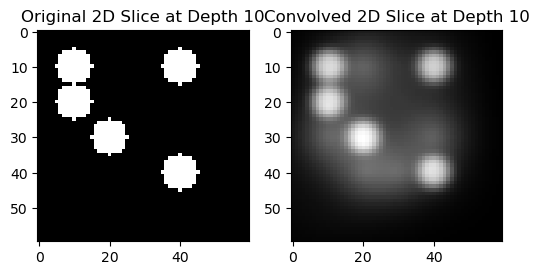

In [ ]:
# Convolve the ball with the PSF
convolved = conv_3D(ball_tensor, IPSF)
print("convolved shape:",convolved.shape)

slice_index = 10
view_index = 10

slice_to_visualize = ball_tensor[:,:,slice_index]
view_slice = convolved[:,:,view_index]

fig, ax = plt.subplots(1,2,figsize=(6, 3))
ax[0].imshow(slice_to_visualize.cpu(),cmap='gray', aspect='equal')
ax[0].set_title(f"Original 2D Slice at Depth {slice_index}")
ax[1].imshow(view_slice.cpu(),cmap='gray', aspect='equal')
ax[1].set_title(f"Convolved 2D Slice at Depth {slice_index}")
plt.show()

In [ ]:
import torch.nn as nn
import torch.optim as optim

class FFN_3D(nn.Module):
    def __init__(self):
        super(FFN_3D, self).__init__()
        self.fc1 = nn.Linear(1024, 512)  # First fully connected layer
        self.fc2 = nn.Linear(512, 512)  # Second fully connected layer
        self.fc3 = nn.Linear(512, 512)  # Third fully connected layer
        self.fc4 = nn.Linear(512, 1)    # Output layer for RGB values

    def forward(self, x):
        x = x.view(-1, 1024)  # Flatten the input
        x = torch.relu(self.fc1(x))  # Apply ReLU activation to the first layer
        x = torch.relu(self.fc2(x))  # Apply ReLU activation to the second layer
        x = torch.relu(self.fc3(x))  # Apply ReLU activation to the third layer
        x = torch.sigmoid(self.fc4(x))  # Apply sigmoid activation to the output layer for RGB values
        return x

In [ ]:
def input_mapping(x, B):
  if B is None:
    return x
  else:
    x_proj = (2.*np.pi*x) @ B.T
    return np.concatenate([np.sin(x_proj), np.cos(x_proj)], axis=-1)

# B
mapping_size = 512
B_g10 = np.random.normal(size=(mapping_size, 3))*10
B_g10.shape

(512, 3)

In [ ]:
# Data
input_3D = ball_tensor  #3D Shape
x_coords = np.linspace(0, 1, input_3D.shape[0], endpoint=False)
y_coords = np.linspace(0, 1, input_3D.shape[0], endpoint=False)
z_coords = np.linspace(0, 1, input_3D.shape[0], endpoint=False)

print(f'x: {x_coords.shape}, y: {y_coords.shape}, z: {z_coords.shape}')

input_coords = torch.tensor(np.stack(np.meshgrid(y_coords, x_coords,z_coords), -1),dtype=torch.float32) #input coordinates for 3D Shape
target = convolved # 3D convolved output

input_mapped = torch.tensor(input_mapping(input_coords,B_g10),dtype=torch.float32,device=device)


print(f'input shape: {input_coords.shape} \ninput_mapped shape: {input_mapped.shape} \ntarget shape: {target.shape}')

x: (60,), y: (60,), z: (60,)
input shape: torch.Size([60, 60, 60, 3]) 
input_mapped shape: torch.Size([60, 60, 60, 1024]) 
target shape: torch.Size([60, 60, 60])


In [ ]:
num_epochs = 2000 #epochs per frame
learning_rate = 0.001
milestones = [300, 1500]
loss_history = []
num_train_depths = target.shape[2]
train_depth_step = 2

# Instantiate the model
model = FFN_3D()
model = model.to(device)
model = nn.DataParallel(model)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.5)

train_depths = [i for i in range (0,num_train_depths,train_depth_step)]

# Training loop
for epoch in range(num_epochs):
    optimizer.zero_grad()  # Zero the gradients
    input = input_mapped

    output = model(input)  # Forward pass

    output = output.view(60,60,60)
    output_psf = conv_3D(output,IPSF)

    loss = criterion(output_psf, target)  # Compute loss
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights
    scheduler.step() # Update the learning rate

    loss_history.append(loss.item())
    if (epoch+1) % 20 == 0:
      print(f'Epoch [{epoch+1}/{num_epochs}], LR: {round(current_lr,8)} , Loss: {loss.item():.8f}')
    current_lr = optimizer.param_groups[0]['lr']

now = datetime.datetime.now()
now = now + datetime.timedelta(hours=5, minutes=30)
date_time = now.strftime("%Y-%m-%d_%H-%M-%S")

# Save the model
torch.save(model.state_dict(), f'model_{date_time}.pt')

Epoch [20/2000], LR: 0.001 , Loss: 0.02134480
Epoch [40/2000], LR: 0.001 , Loss: 0.00965059
Epoch [60/2000], LR: 0.001 , Loss: 0.00626285
Epoch [80/2000], LR: 0.001 , Loss: 0.00423736
Epoch [100/2000], LR: 0.001 , Loss: 0.00279914
Epoch [120/2000], LR: 0.001 , Loss: 0.00109769
Epoch [140/2000], LR: 0.001 , Loss: 0.00056467
Epoch [160/2000], LR: 0.001 , Loss: 0.00041686
Epoch [180/2000], LR: 0.001 , Loss: 0.00033794
Epoch [200/2000], LR: 0.001 , Loss: 0.00028887
Epoch [220/2000], LR: 0.001 , Loss: 0.00024204
Epoch [240/2000], LR: 0.001 , Loss: 0.00021321
Epoch [260/2000], LR: 0.001 , Loss: 0.00029216
Epoch [280/2000], LR: 0.001 , Loss: 0.00021594
Epoch [300/2000], LR: 0.001 , Loss: 0.00018805
Epoch [320/2000], LR: 0.0005 , Loss: 0.00017927
Epoch [340/2000], LR: 0.0005 , Loss: 0.00017025
Epoch [360/2000], LR: 0.0005 , Loss: 0.00016094
Epoch [380/2000], LR: 0.0005 , Loss: 0.00015316
Epoch [400/2000], LR: 0.0005 , Loss: 0.00014572
Epoch [420/2000], LR: 0.0005 , Loss: 0.00013883
Epoch [440/

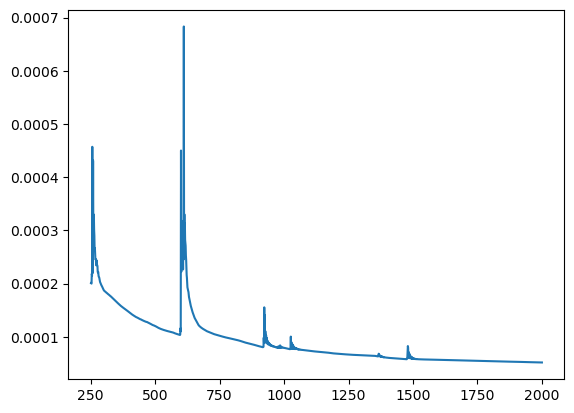

In [ ]:
t = 250
plt.plot(range(t+1,len(loss_history)+1),loss_history[t:])
plt.show()

In [ ]:
def plot_h(tensor):
  data = tensor.cpu().numpy().ravel()
  data = data[data>0.1]
  data = data[data<0.99]
  # Plot the histogram
  f = plt.figure(figsize=(4,2))
  plt.hist(data, bins=50, color='blue', alpha=0.7)
  plt.title('Histogram')
  plt.xlabel('Value')
  plt.ylabel('Frequency')
  plt.grid(True)
  plt.show()

def view_3D(gt,target,out,pixel_i=0,depth=-1): # func for compare 3D shapes
  p = out.cpu().numpy()
  x, y, z = np.where(p > pixel_i)

  if depth > -1 :
    filtered_indices = np.where(z == depth)
    x = x[filtered_indices]
    y = y[filtered_indices]
    z = z[filtered_indices]

  # Assuming Nx, Ny, and Nz are defined
  Nx, Ny, Nz = p.shape

  # Create a figure with two 3D subplots
  fig = plt.figure(figsize=(12,4))

  # Create the first 3D subplot
  ax1 = fig.add_subplot(133, projection='3d')
  ax1.scatter(x, y, z, c='k', marker='o')
  ax1.set_xlim(0, Nx)
  ax1.set_ylim(0, Ny)
  ax1.set_zlim(0, Nz)
  ax1.set_xlabel('X')
  ax1.set_ylabel('Y')
  ax1.set_zlabel('Z')
  ax1.set_title(f'Pred | Depth: {depth} | Intensity > {pixel_i}')

  # Create the second 3D subplot
  ax2 = fig.add_subplot(131, projection='3d')
  # Adjust as needed, for example:

  x1,y1,z1 = np.where(gt.cpu() > pixel_i)

  if depth > -1 :
    fil = np.where(z1 == depth)
    x1 = x1[fil]
    y1 = y1[fil]
    z1 = z1[fil]

  ax2.scatter(x1, y1, z1, c='r', marker='o')
  ax2.set_xlim(0, Nx)
  ax2.set_ylim(0, Ny)
  ax2.set_zlim(0, Nz)
  ax2.set_xlabel('X')
  ax2.set_ylabel('Y')
  ax2.set_zlabel('Z')
  ax2.set_title(f'GT | Depth: {depth} | Intensity > {pixel_i}')

  # Create the 3rd 3D subplot
  ax2 = fig.add_subplot(132, projection='3d')
  # Adjust as needed, for example:

  x1,y1,z1 = np.where(target.cpu() > pixel_i)

  if depth > -1 :
    fil = np.where(z1 == depth)
    x1 = x1[fil]
    y1 = y1[fil]
    z1 = z1[fil]

  ax2.scatter(x1, y1, z1, c='b', marker='o')
  ax2.set_xlim(0, Nx)
  ax2.set_ylim(0, Ny)
  ax2.set_zlim(0, Nz)
  ax2.set_xlabel('X')
  ax2.set_ylabel('Y')
  ax2.set_zlabel('Z')
  ax2.set_title(f'GT*PSF | Depth: {depth} | Intensity > {pixel_i}')

  plt.tight_layout()
  plt.show()

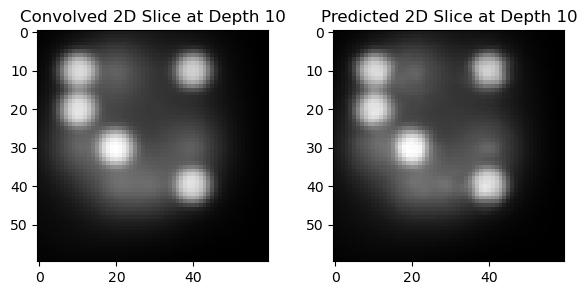

In [ ]:
pred = model(input).detach()
pred = pred.reshape(60,60,60)

pred_conv = conv_3D(pred,IPSF)
p_test = pred_conv[pred_conv > 0.9]
d = 10

fig, ax = plt.subplots(1,2,figsize=(7, 3))
ax[0].imshow(target[:,:,d].cpu(),cmap='gray', aspect='equal')
ax[0].set_title(f"Convolved 2D Slice at Depth {slice_index}")
ax[1].imshow(pred_conv[:,:,d].cpu(),cmap='gray', aspect='equal')
ax[1].set_title(f"Predicted 2D Slice at Depth {slice_index}")


plt.show()
# plot_h(view_slice.cpu())
# plot_h(pred_conv[:,:,view_index].cpu())

In [ ]:
torch.save(pred,'pred_tensor_x512_e2000.pt')

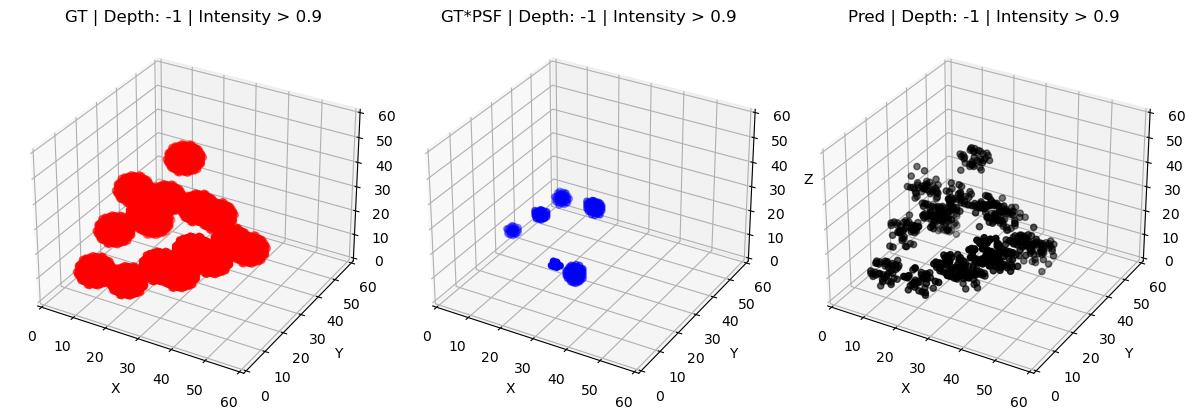

In [ ]:
view_3D(ball_tensor,target,pred,0.9)

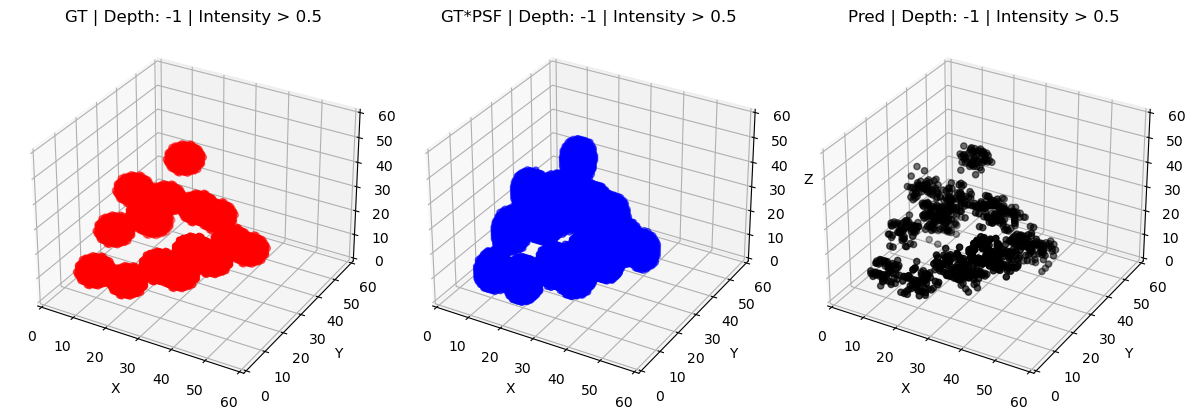

In [ ]:
view_3D(ball_tensor,target,pred,0.5)

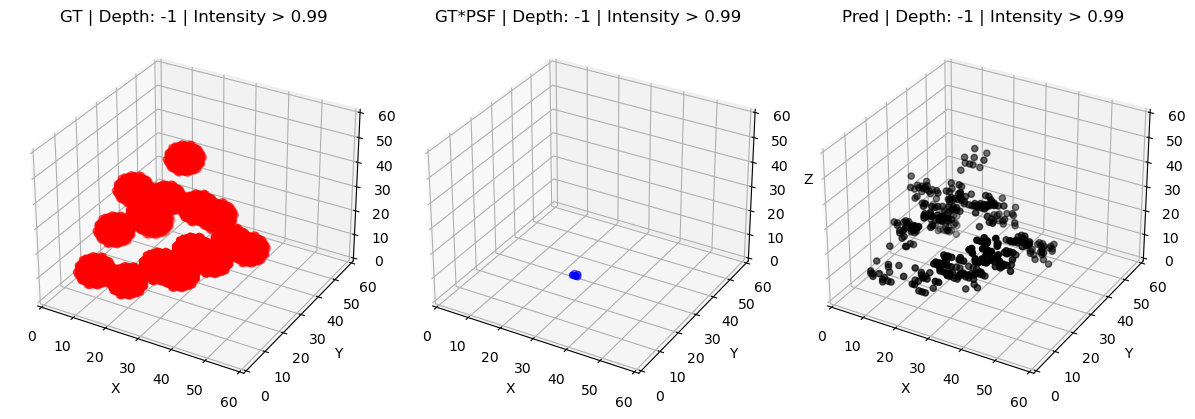

In [ ]:
view_3D(ball_tensor,target,pred,0.99)

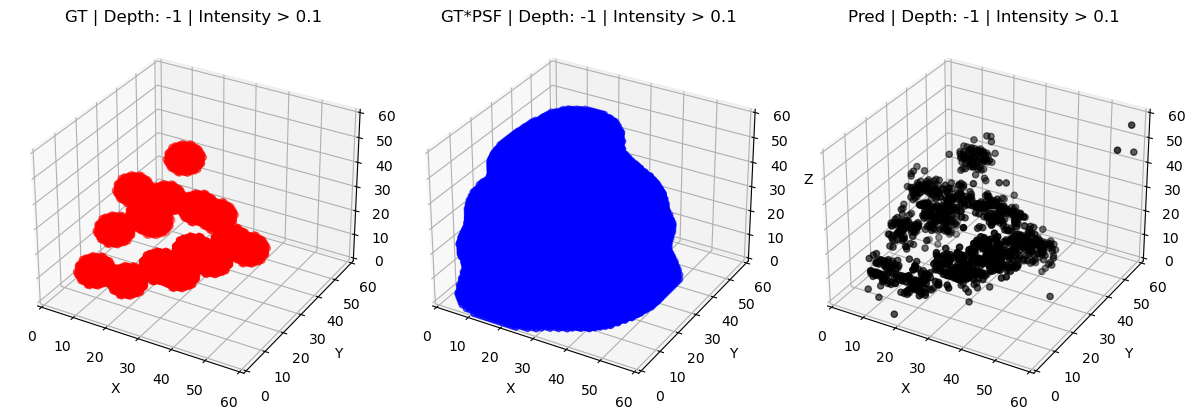

In [ ]:
view_3D(ball_tensor,target,pred,0.1)

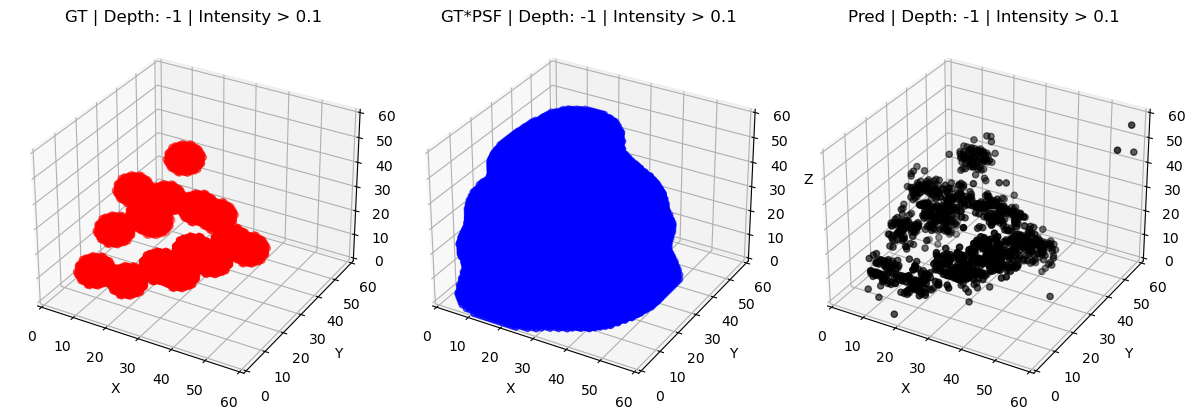

In [ ]:
view_3D(ball_tensor,target,pred,0.1)

In [ ]:
!pip install imageio-ffmpeg

     â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â”â” 26.9/26.9 MB 35.2 MB/s eta 0:00:0000:0100:01


In [ ]:
import imageio
from IPython.display import HTML
from base64 import b64encode

#create a video output
tensor_cpu = ball_tensor.cpu()
c = convolved.cpu()
pred_conv_cpu = pred_conv.cpu()

outputs = []
gen = []
raw = []
for i in range(60):
  img1 = tensor_cpu[:,:,i].numpy()
  img2 = pred_conv_cpu[:,:,i].numpy()
  img3 = c[:,:,i].numpy()
  raw.append(img1)
  outputs.append(img2)
  gen.append(img3)

len(outputs)

def normalize_image(img):
    img_min = img.min()
    img_max = img.max()
    return (img - img_min) / (img_max - img_min)

outputs_normalized = [normalize_image(img) for img in outputs]
raw_normalized = [normalize_image(img) for img in raw]
gen_normalized = [normalize_image(img) for img in gen]

outputs_uint8 = [(255 * img).astype(np.uint8) for img in outputs_normalized]
raw_uint8 = [(255 * img).astype(np.uint8) for img in raw_normalized]
gen_uint8 = [(255 * img).astype(np.uint8) for img in gen_normalized]

all_preds = np.concatenate([raw_uint8,gen_uint8,outputs_uint8], axis=-1)

video_filename = 'output_video.mp4'
imageio.mimwrite(video_filename, all_preds, fps=5)  # Change fps if needed

# Read the video and embed it in the notebook
with open(video_filename, 'rb') as f:
    mp4 = f.read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

# Display the video
HTML(f'''
<video width=800 controls>
    <source src="{data_url}" type="video/mp4">
</video>
''')

/tmp/ipykernel_28/464027620.py:26: RuntimeWarning: invalid value encountered in divide
  return (img - img_min) / (img_max - img_min)
[swscaler @ 0x5f10800] Warning: data is not aligned! This can lead to a speed loss


In [ ]:
p = pred.cpu().numpy()

In [ ]:
import plotly.graph_objs as go
import plotly.offline as pyo
import numpy as np

p_i = 0.1

x3, y3, z3 = np.where((p < p_i) & (p>0.01) )  # Extract coordinates where balls are present
trace2 = go.Scatter3d(
    x=x3,
    y=y3,
    z=z3,
    mode='markers',
    marker=dict(size=5, color='green'),  # Adjust marker size and color as needed
    name = f'Intensity < {p_i}',
    opacity=0.6,
)

# Create the layout for the 3D plot
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='X'),
        yaxis=dict(title='Y'),
        zaxis=dict(title='Z'),
    )
)

# Create a 3D scatter plot for the balls
x, y, z = np.where(p > p_i)  # Extract coordinates where balls are present
trace = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(size=5, color='red'),  # Adjust marker size and color as needed
    name = f'Intensity > {p_i}'
)

# Create the layout for the 3D plot
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='X'),
        yaxis=dict(title='Y'),
        zaxis=dict(title='Z'),
    )
)

x1, y1, z1 = np.where(ball_tensor.cpu() > 0)  # Extract coordinates where balls are present
GT = go.Scatter3d(
    x=x1,
    y=y1,
    z=z1,
    mode='markers',
    marker=dict(size=2, color='blue',),  # Adjust marker size and color as needed
    name = 'GT',
    opacity=0.4,
)

# Create the layout for the 3D plot
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='X'),
        yaxis=dict(title='Y'),
        zaxis=dict(title='Z'),
    )
)

# Create the figure and plot
fig = go.Figure(data=[GT,trace], layout=layout)

# Save the interactive plot as an HTML file
pyo.plot(fig, filename=f'interactive_balls_plot_.html')
fig.show()

In [ ]:
import plotly.graph_objects as go

p = pred.cpu().numpy()
x, y, z = np.where(p > 0.9)

# Sample point cloud data (replace this with your point cloud coordinates and intensities)
k = 60
intensities = p[x,y,z].flatten() # Replace with your actual intensities
intensities = 1-intensities


# Create a 3D scatter plot with color mapped to intensities
fig = go.Figure(data=[
    go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers',
        marker=dict(
            size=5,
            color=intensities,  # Assign intensities as the color values
            colorscale='Gray',  # You can choose a different colormap
            colorbar=dict(title='Intensities'),
            opacity=0.5,
        )
    )
])

# Set axis labels
fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'))
pyo.plot(fig, filename='result_plot_i01_op04.html')
# Show the plot in Colab
fig.show()

In [ ]:
pyo.plot(fig, filename='result_plot_i09_op05.html')

'result_plot_i09_op05.html'